In [191]:
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense, Flatten, Reshape, Activation, Lambda, Permute
from keras.layers import Input
from keras.layers.merge import add
from keras.initializers import RandomNormal
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.utils import plot_model
from IPython.core.display import Image, display
import numpy as np

In [243]:
DIM = 200
SEQ_LEN = 32
RANDOM_DIM = 128
VOCAB_SIZE = 128

In [244]:
def ResBlock(name):
    inputs = Input(shape=(SEQ_LEN, DIM))
    block = Sequential(name=name+'_res')
    block.add(Activation('relu', input_shape=(SEQ_LEN, DIM)))
    block.add(Conv1D(DIM, 5, padding='same', name=name+"_cov1", input_shape=(SEQ_LEN, DIM)))
    block.add(Activation('relu'))
    block.add(Conv1D(DIM, 5, padding='same', name=name+"_cov2", input_shape=(SEQ_LEN, DIM)))
    merged = Lambda(lambda q: q[0]*0.3 + q[1])([block(inputs), inputs])    
    block_model = Model(inputs=inputs, outputs=merged)
    return block_model

In [245]:
def Generator():
    generator = Sequential()
    generator.add(Dense(SEQ_LEN*DIM, input_shape=(RANDOM_DIM,)))
    generator.add(Reshape((SEQ_LEN, DIM)))
    for i in range(5):
        generator.add(ResBlock('Generator.{0:d}'.format(i)))
    generator.add(Conv1D(VOCAB_SIZE, 5, padding='same'))
    generator.add(Activation('softmax'))
    return generator

In [262]:
def Discriminator():
    discriminator = Sequential()
    discriminator.add(Conv1D(DIM, 5, padding='same', input_shape=(SEQ_LEN, VOCAB_SIZE)))
    for i in range(5):
        discriminator.add(ResBlock('Generator.{0:d}'.format(i)))
    discriminator.add(Reshape((SEQ_LEN*DIM,)))   
    discriminator.add(Dense(1, activation='softmax'))
    return discriminator

In [259]:
g = Generator()
print(g.output_shape)
g.summary()

(None, 32, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 6400)              825600    
_________________________________________________________________
reshape_24 (Reshape)         (None, 32, 200)           0         
_________________________________________________________________
model_156 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_157 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_158 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_159 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_160 (Model)            (None, 32, 200)           40040

In [263]:
d = Discriminator()
print(d.output_shape)
d.summary()

(None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 32, 200)           128200    
_________________________________________________________________
model_166 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_167 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_168 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_169 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
model_170 (Model)            (None, 32, 200)           400400    
_________________________________________________________________
reshape_25 (Reshape)         (None, 6400)              0         


In [167]:
t = ResBlock('test', 100)

In [168]:
t.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_46 (InputLayer)            (None, 10, 20)        0                                            
____________________________________________________________________________________________________
test_res (Sequential)            (None, 10, 20)        4040        input_46[0][0]                   
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 10, 20)        0           test_res[1][0]                   
                                                                   input_46[0][0]                   
Total params: 4,040
Trainable params: 4,040
Non-trainable params: 0
____________________________________________________________________________________________________


In [169]:
pred = t.predict(np.ones((100, SEQ_LEN, DIM)))

In [114]:
pred[0]

array([[ 0.29562837,  0.01579072,  0.31917942,  0.13410902,  0.23180808,
         0.07615251,  0.29214591, -0.16874602, -0.34903234, -0.05233342,
        -0.24116269,  0.14034885, -0.04277074,  0.47394556, -0.14474888,
        -0.04749283,  0.13330026, -0.19548459, -0.02450358,  0.14970438],
       [ 0.28161544,  0.26857752,  0.27629855,  0.04484605,  0.25496271,
         0.0211953 ,  0.3600153 , -0.06856856, -0.07233518,  0.10362522,
        -0.22533819,  0.24838901,  0.01642642,  0.60802692, -0.07529299,
         0.06503887,  0.16622944, -0.25470734, -0.0198482 ,  0.12563322],
       [ 0.18010779,  0.41392341,  0.32418075,  0.15345094,  0.22445905,
        -0.11105887,  0.2296837 ,  0.01175779, -0.24815305,  0.03963525,
        -0.393152  ,  0.45300877, -0.09292503,  0.79209477, -0.02068807,
         0.0316645 ,  0.14314048, -0.3667255 ,  0.03254921,  0.11423583],
       [ 0.18010779,  0.41392341,  0.32418075,  0.15345094,  0.22445905,
        -0.11105887,  0.2296837 ,  0.01175779, -

In [49]:
plot_model(t, to_file='model.png')

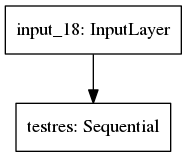

In [53]:
display(Image('model.png', width=100, unconfined=True))

In [ ]:
class Discriminator(object):
    def __init__(self):
        self.x_dim = 784
        self.name = 'mnist/dcgan/discriminator'
        self.initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)
        self.regularizer = regularizers.l2(2.5e-5)

    def __call__(self):
        model = Sequential()
        model.add(Reshape((28, 28, 1), input_shape=(784,)))
        # Convolution Layer 1
        model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), \
            kernel_initializer=self.initializer))
        model.add(LeakyReLU())

        # Convolution Layer 2
        model.add(Conv2D(128, kernel_size=(4, 4), strides=(2, 2), \
            kernel_initializer=self.initializer))
        model.add(LeakyReLU())

        # Batch Normalization
        model.add(BatchNormalization())

        # Flatten the input
        model.add(Flatten())

        # Dense Layer
        model.add(Dense(1024, kernel_initializer=self.initializer))
        model.add(LeakyReLU())

        # Batch Normalization
        model.add(BatchNormalization())

        # To the output that has two classes
        model.add(Dense(2, activation='softmax'))

return model